In this notebook we'll explore the solution found by our classifier.

In [1]:
#!pip install seaborn

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import utils
import rnn

%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.


In [234]:
%autoreload
import utils
import rnn

### Re-create the training data using saved model params

In [173]:
# Pick a model to load and extract the hyperparams.

#model_name = 'models/64_64_64_0.5_False_20_20000_0.3_64_0.0_002_0.53010_0.73065_titles.h5'
model_name = 'models/256_256_256_0.5_True_32_20000_0.0_64_0.0_1_32_titles_002_0.67408_0.50655_titles.h5'

gru_dim, embed_dim, dense_dim, dropout, bidirectional, maxlen, topn, test_size, batch_size = \
  utils.parse_model_name(model_name)
  
# Load the keras model
model = load_model(model_name)

In [174]:
%%time

# Load the source data frame

filepath = '../data/data-True-0.pkl'
df, keep_stops, min_sents, vocab, w2i, i2w = utils.read_dataset(filepath)

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.51 s


In [175]:
%%time

# Filter out uncommon words using parameters parsed from model name.

df['encoded_text'] = utils.filter_top_words(df['encoded_text'].tolist(), topn)

CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 79.1 ms


In [176]:
# Create input/output data

X = pad_sequences(df['encoded_text'], maxlen=maxlen, value=topn, 
                  padding='post', truncating='post')

Y = df['encoded_label'].tolist()

In [177]:
# Get output probabilities for every observation.

Ypred = model.predict(X)

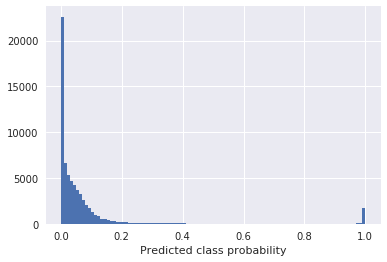

In [178]:
# Look at distribution.  There are some funny extreme modes we should try to understand.

fig, ax = plt.subplots()
ax.set_xlabel('Predicted class probability')
ax = plt.hist(Ypred[:, 10], 100)

In [196]:
def plot_domain_scores(df, Y, domain, thresh=0.9):
    domain_idx = np.where(df['domain'] == domain)[0]
    if len(domain_idx) == 0:
        print('none found')    
        return
    df = pd.DataFrame(df.iloc[domain_idx, :])
    Y = Y[domain_idx, :]
    
    col_idx = df['encoded_label'].iloc[0]
    Y = Y[:, col_idx]
    
    row_idx = np.where(Y > thresh)[0]
    Y = Y[row_idx]
    df = pd.DataFrame(df.iloc[row_idx, :])
    
    df['probs'] = Y
    
    return df

probs = plot_domain_scores(df, Ypred, 'cnn.com')

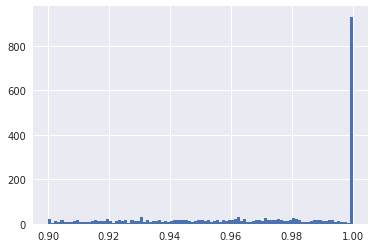

In [197]:
probs['probs'].hist(bins=100)

In [198]:
ix = 68
probs.index[ix], probs['probs'].iloc[ix], probs['tokenized'].iloc[ix]

(2290,
 0.99998534,
 u'classmate_NOUN use_VERB heimlich_PROPN after_ADP student_NOUN choke_VERB cnn_PROPN video_PROPN')

In [200]:
probs.iloc[ix, :]

title            Classmate uses Heimlich after student chokes -...
label                                                      liberal
url              http://www.cnn.com/videos/us/2017/03/24/studen...
domain                                                     cnn.com
tokenized        classmate_NOUN use_VERB heimlich_PROPN after_A...
encoded_text              [6474, 135, 9956, 17, 152, 4246, 43, 55]
encoded_label                                                    6
probs                                                     0.999985
Name: 2290, dtype: object

In [183]:
df.iloc[2290, :]

title            Trump blames Democrats for House GOP failure t...
label                                                      liberal
url              http://www.cbsnews.com/news/trump-says-both-pa...
domain                                                 cbsnews.com
tokenized        trump_PROPN blame_VERB democrats_PROPN for_ADP...
encoded_text      [0, 681, 76, 7, 24, 47, 947, 4, 587, 72, 89, 82]
encoded_label                                                    4
Name: 2307, dtype: object

In [214]:
probs

,title,label,url,domain,tokenized,encoded_text,encoded_label,probs
24,Poachers killed rare rhinoceros in French zoo ...,liberal,http://www.cnn.com/videos/world/2017/03/09/par...,cnn.com,poacher_NOUN kill_VERB rare_ADJ rhinoceros_NOU...,"[6409, 60, 2173, 19458, 2, 1432, 2297, 43, 55]",6,0.999782
40,Van Jones: There is a danger normalizing Trump...,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,van_PROPN jones_PROPN there_ADV be_VERB a_DET ...,"[2515, 1722, 241, 5, 10, 3043, 8928, 0, 43, 55]",6,0.999998
170,Barton: 'I will buy Waffle House for everyone'...,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,barton_PROPN -PRON-_PRON will_VERB buy_VERB wa...,"[14953, 6, 30, 960, 8987, 24, 7, 813, 115, 6, ...",6,0.999972
177,NYT columnist calls Trump a pathological liar ...,liberal,http://www.cnn.com/videos/politics/2017/03/08/...,cnn.com,nyt_PROPN columnist_NOUN call_VERB trump_PROPN...,"[1079, 4803, 66, 0, 10, 13430, 5981, 43, 55]",6,0.999856
181,Dave Chappelle crashes town hall - CNN Video,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,dave_PROPN chappelle_PROPN crash_VERB town_NOU...,"[3915, 6582, 1261, 499, 1082, 43, 55]",6,0.999924
216,Tapper: Not even Trump's team believes claims ...,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,tapper_NOUN not_ADV even_ADV trump_PROPN team_...,"[4856, 36, 375, 0, 292, 721, 202, 43, 55]",6,0.999993
224,EPA chief: Carbon dioxide not 'primary contrib...,liberal,http://www.cnn.com/2017/03/09/politics/scott-p...,cnn.com,epa_PROPN chief_NOUN carbon_NOUN dioxide_NOUN ...,"[346, 446, 2996, 8913, 36, 4306, 6248, 4, 7731...",6,0.944082
289,Sources: FBI investigation continues into 'odd...,liberal,http://www.cnn.com/2017/03/09/politics/fbi-inv...,cnn.com,source_NOUN fbi_PROPN investigation_NOUN conti...,"[502, 176, 353, 570, 81, 6069, 3216, 2046, 473...",6,0.962747
300,"Boy meets Queen, then this happens - CNN Video",liberal,http://www.cnn.com/videos/world/2017/03/09/boy...,cnn.com,boy_NOUN meet_VERB queen_PROPN then_ADV this_D...,"[486, 145, 2511, 421, 46, 291, 43, 55]",6,0.999980
304,Sanders: House plan is Robin Hood in reverse -...,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,sander_NOUN house_PROPN plan_NOUN be_VERB robi...,"[2376, 24, 102, 5, 6618, 7139, 2, 13557, 43, 55]",6,0.999996


In [221]:
topn, embed_dim, dense_dim, gru_dim, maxlen, bidirectional

(20000, 256, 256, 256, 32, True)

In [235]:
in_model, out_model = rnn.split_model_layers(model, topn, embed_dim, dense_dim, gru_dim, 1, maxlen, Ypred.shape[1], bidirectional)

In [236]:
x = rnn.evaluate_sequential_probs([probs['encoded_text'].iloc[1000]], maxlen, topn, in_model, out_model)
np.max(x, axis=1)

(1, 32, 512)


ValueError: Error when checking : expected dense_11_input to have 2 dimensions, but got array with shape (1, 32, 512)

In [233]:
tmp = out_model.layers[1]
tmp